# Academic Research on FER Datasets


### Summary

This project focused on building a comprehensive dataset of academic papers related to Facial Emotion Recognition (FER) by employing web scraping techniques, with an emphasis on utilizing the `requests` library to create a simple yet effective crawler.

#### **1. Use of Requests and the Simplest Crawler:**
The `requests` library was extensively employed to interact with various academic research APIs, such as arXiv, CrossRef, and OpenAlex. Through this approach, data was systematically fetched by making HTTP requests to these APIs, allowing the retrieval of structured information, including paper titles, abstracts, publication dates, citation counts, and mentions of widely used FER datasets.

By sending specific queries to these APIs, a straightforward crawling mechanism was established, which targeted data relevant to the project’s scope (FER research papers from 2020-2024). This demonstrated the implementation of the simplest form of a crawler, which efficiently collected data without the need for complex frameworks, by iterating over a list of FER datasets.

#### **2. Additional Techniques:**
- Extracted data was further processed using regular expressions (`re`) to identify performance metrics such as accuracy and F1 scores from PDF documents.
- The compiled dataset was then stored in a CSV file, demonstrating data persistence and effective handling of the gathered information.

In summary, this project successfully leveraged the `requests` library to create a basic yet powerful crawler, showcasing how fundamental web scraping techniques can be used to collect and analyze academic data from multiple sources.

## 1: Import Libraries

In [1]:
'''to import fitz'''
#pip install PyMuPDF

'to import fitz'

In [2]:
import requests
import pandas as pd
import feedparser
import re
import fitz  
from scholarly import scholarly  
import time


import sys

# Print Python version
print(f"Python version: {sys.version}")

# Print library versions
print(f"requests version: {requests.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"feedparser version: {feedparser.__version__}")
print(f"fitz (PyMuPDF) version: {fitz.__doc__.split()[1]}")  # fitz doesn't have __version__
# scholarly may not have a version attribute, so use pkg_resources as fallback
try:
    print(f"scholarly version: {scholarly.__version__}")
except AttributeError:
    import pkg_resources
    scholarly_version = pkg_resources.get_distribution("scholarly").version
    print(f"scholarly version: {scholarly_version}")


Python version: 3.12.1 (tags/v3.12.1:2305ca5, Dec  7 2023, 22:03:25) [MSC v.1937 64 bit (AMD64)]
requests version: 2.32.3
pandas version: 2.2.2
feedparser version: 6.0.11


NameError: name 'fitz' is not defined

## 2: Define FER Datasets

using satasetlist from here:
https://arxiv.org/pdf/1804.08348v2

In [3]:

fer_datasets = ["CK+", "MMI", "JAFFE", "TFD", "FER-2013", "AFEW7.0", 
    "SFEW2.0", "Multi-PIE", "BU-3DFE", "Oulu-CASIA", 
    "RaFD", "KDEF", "EmotioNet", "RAF-DB", "AffectNet", "ExpW"]


## 3: Search arXiv API

In [4]:
import requests

def search_arxiv(dataset_name, max_results=50):
    print(f"Searching arXiv for: {dataset_name}")
    encoded_query = dataset_name.replace(" ", "+")
    url = f"http://export.arxiv.org/api/query?search_query=all:{encoded_query}&start=0&max_results={max_results}&sortBy=submittedDate&sortOrder=descending"
    response = feedparser.parse(url)
    
    papers = []
    for entry in response.entries:
        paper_info = {
            'Title': entry.title,
            'Published': entry.published,
            'Authors': [author['name'] for author in entry.authors],
            'Link': entry.link,
            'Summary': entry.summary,
            'arXiv_ID': entry.id.split('/')[-1],  # Extract arXiv ID for later citation lookup
            'Dataset': dataset_name
        }
        papers.append(paper_info)
    return papers

# Collect data from arXiv for each dataset
arxiv_results = []
for dataset in fer_datasets:
    arxiv_results.extend(search_arxiv(dataset))

# Store results in a DataFrame
arxiv_df = pd.DataFrame(arxiv_results)
arxiv_df.head()


Searching arXiv for: CK+
Searching arXiv for: MMI
Searching arXiv for: JAFFE
Searching arXiv for: TFD
Searching arXiv for: FER-2013
Searching arXiv for: AFEW7.0
Searching arXiv for: SFEW2.0
Searching arXiv for: Multi-PIE
Searching arXiv for: BU-3DFE
Searching arXiv for: Oulu-CASIA
Searching arXiv for: RaFD
Searching arXiv for: KDEF
Searching arXiv for: EmotioNet
Searching arXiv for: RAF-DB
Searching arXiv for: AffectNet
Searching arXiv for: ExpW


,Title,Published,Authors,Link,Summary,arXiv_ID,Dataset
0,Semantical Analysis of Intuitionistic Modal Lo...,2024-08-01T03:39:16Z,"[Jim de Groot, Ian Shillito, Ranald Clouston]",http://arxiv.org/abs/2408.00262v2,The intuitionistic modal logics considered bet...,2408.00262v2,CK+
1,Bridging the Gap: A Survey and Classification ...,2024-07-19T12:35:17Z,"[Paolo Modesti, Lewis Golightly, Louis Holmes,...",http://arxiv.org/abs/2407.14255v1,The majority of Ethical Hacking (EH) tools uti...,2407.14255v1,CK+
2,"Tactics, Techniques, and Procedures (TTPs) in ...",2024-07-11T14:18:41Z,"[Ying Zhang, Xiaoyan Zhou, Hui Wen, Wenjia Niu...",http://arxiv.org/abs/2407.08532v1,"Nowadays, the open-source software (OSS) ecosy...",2407.08532v1,CK+
3,Source regions of carbonaceous meteorites and ...,2024-06-28T08:18:43Z,"[M. Brož, P. Vernazza, M. Marsset, R. P. Binze...",http://arxiv.org/abs/2406.19727v2,The present work aims to determine the source ...,2406.19727v2,CK+
4,When is an Embedding Model More Promising than...,2024-06-11T18:13:46Z,"[Maxime Darrin, Philippe Formont, Ismail Ben A...",http://arxiv.org/abs/2406.07640v1,Embedders play a central role in machine learn...,2406.07640v1,CK+


### Count citations
The Semantic Scholar API is used to access citation data since arXiv doesn’t provide it. 

!! respect API rate limits to avoid being blocked.


In [ ]:
#pip install semanticscholar

In [ ]:
import time
from semanticscholar import SemanticScholar

# Initialize the Semantic Scholar API
sch = SemanticScholar()

def filter_by_citations(arxiv_papers, min_citations=100, max_retries=3, sleep_time=2):
    filtered_papers = []
    
    for paper in arxiv_papers:
        arxiv_id = paper["arXiv_ID"].split("v")[0]  # Remove the version part of the arXiv ID

        for attempt in range(max_retries):
            try:
                # Retrieve paper info using Semantic Scholar
                paper_info = sch.get_paper(f'arXiv:{arxiv_id}')
                
                # Extract the citation count
                citation_count = paper_info.get('citationCount', 0)
                
                # Only add paper if citation count exceeds the threshold
                if citation_count > min_citations:
                    paper['Citation Count'] = citation_count
                    filtered_papers.append(paper)
                
                # Break the retry loop if successful
                break
            
            except Exception as e:
                print(f"Error retrieving citation data for paper {arxiv_id}: {e}")
                
                # If the maximum number of retries is reached, skip this paper
                if attempt == max_retries - 1:
                    print(f"Skipping paper {arxiv_id} after {max_retries} failed attempts.")
                else:
                    # Wait before retrying
                    time.sleep(sleep_time)
    
    return filtered_papers

# Filter the arXiv papers based on citation count > 100
arxiv_filtered_results = filter_by_citations(arxiv_results[:2], min_citations=100)

# Store results in a DataFrame
arxiv_filtered_df = pd.DataFrame(arxiv_filtered_results)
arxiv_filtered_df.head()


Error retrieving citation data for paper 2408.00262: RetryError[<Future at 0x1cd10f786d0 state=finished raised ConnectionRefusedError>]
Error retrieving citation data for paper 2408.00262: 'Paper' object has no attribute 'get'


## 4: Use CrossRef API for Citation Counts

In [8]:
def search_crossref(dataset_name, max_results=10):
    print(f"Searching CrossRef for: {dataset_name}")
    base_url = 'https://api.crossref.org/works'
    params = {
        'query': dataset_name,
        'filter': 'from-pub-date:2020,until-pub-date:2024',
        'rows': max_results
    }
    response = requests.get(base_url, params=params).json()
    
    papers = []
    for item in response['message']['items']:
        # Extract the citation count
        citation_count = item.get('is-referenced-by-count', 0)
        
        # Include only papers with more than 100 citations
        if citation_count > 5:
            paper_info = {
                'Title': item.get('title', ['No title available'])[0],  # Safely access the 'title' key
                'Published': item.get('published-print', {}).get('date-parts', [[None]])[0][0],
                'DOI': item.get('DOI', 'No DOI available'),
                'Citation Count': citation_count,
                'Dataset': dataset_name
            }
            papers.append(paper_info)
    
    return papers

# Collect data from CrossRef, ensuring only papers with > 100 citations are included
crossref_results = []
for dataset in fer_datasets:
    crossref_results.extend(search_crossref(dataset))

# Store results in a DataFrame
crossref_df = pd.DataFrame(crossref_results)
crossref_df.head()


Searching CrossRef for: CK+
Searching CrossRef for: MMI
Searching CrossRef for: JAFFE
Searching CrossRef for: TFD
Searching CrossRef for: FER-2013
Searching CrossRef for: AFEW7.0
Searching CrossRef for: SFEW2.0
Searching CrossRef for: Multi-PIE
Searching CrossRef for: BU-3DFE
Searching CrossRef for: Oulu-CASIA
Searching CrossRef for: RaFD
Searching CrossRef for: KDEF
Searching CrossRef for: EmotioNet
Searching CrossRef for: RAF-DB
Searching CrossRef for: AffectNet
Searching CrossRef for: ExpW


,Title,Published,DOI,Citation Count,Dataset
0,SIAT-3DFE: A High-Resolution 3D Facial Express...,2020,10.1109/access.2020.2979518,13,BU-3DFE
1,Facial Action Unit Recognition in the Wild wit...,2020,10.1109/cvprw50498.2020.00213,6,EmotioNet
2,Simultaneous Prediction of Valence/Arousal and...,2020,10.1016/j.procs.2020.03.134,13,AffectNet


## 5: Collect Data from Scholarly

In [17]:
def search_scholarly(dataset_name):
    search_query = scholarly.search_pubs(dataset_name)
    papers = []
    
    for _ in range(1):  # Limit to 10 results for demonstration purposes
        try:
            paper = next(search_query)
            paper_info = {
                'Title': paper['bib']['title'],
                'Authors': paper['bib']['author'],
                'Year': paper['bib'].get('pub_year', None),
                'Cited By': paper.get('num_citations', 100),
                'Dataset': dataset_name
            }
            papers.append(paper_info)
            time.sleep(2)  # Avoid getting blocked by rate limits
        except StopIteration:
            break
    return papers

# Collect data from Scholarly for each dataset
scholarly_results = []
for dataset in fer_datasets:
    scholarly_results.extend(search_scholarly(dataset))

# Store results in a DataFrame
scholarly_df = pd.DataFrame(scholarly_results)
scholarly_df.head()

,Title,Authors,Year,Cited By,Dataset
0,The extended cohn-kanade dataset (ck+): A comp...,"[P Lucey, JF Cohn, T Kanade, J Saragih]",2010,5129,CK+
1,The multiple mini-interview (MMI) for student ...,"[A Pau, K Jeevaratnam, YS Chen, AA Fall, C Khoo]",2013,244,MMI
2,Performance comparisons of facial expression r...,"[FY Shih, CF Chuang, PSP Wang]",2008,201,JAFFE
3,Time-frequency processing of nonstationary sig...,"[B Boashash, G Azemi]",2013,118,TFD
4,Deep learning approaches for facial emotion re...,"[P Giannopoulos, I Perikos, I Hatzilygeroudis]",2018,207,FER-2013


In [ ]:
scholarly

## 6: Combine All Data

In [22]:
# Merge all collected data into a single DataFrame
combined_df = pd.concat([arxiv_df, crossref_df, scholarly_df], axis=0, ignore_index=True)
#combined_df = pd.concat([arxiv_df, crossref_df], axis=0, ignore_index=True)

# Display combined data
combined_df.to_csv("FER_academic_dataset.csv", index=False)
combined_df.head()

,Title,Published,Authors,Link,Summary,arXiv_ID,Dataset,DOI,Citation Count,Year,Cited By
0,Semantical Analysis of Intuitionistic Modal Lo...,2024-08-01T03:39:16Z,"[Jim de Groot, Ian Shillito, Ranald Clouston]",http://arxiv.org/abs/2408.00262v2,The intuitionistic modal logics considered bet...,2408.00262v2,CK+,NaN,NaN,NaN,NaN
1,Bridging the Gap: A Survey and Classification ...,2024-07-19T12:35:17Z,"[Paolo Modesti, Lewis Golightly, Louis Holmes,...",http://arxiv.org/abs/2407.14255v1,The majority of Ethical Hacking (EH) tools uti...,2407.14255v1,CK+,NaN,NaN,NaN,NaN
2,"Tactics, Techniques, and Procedures (TTPs) in ...",2024-07-11T14:18:41Z,"[Ying Zhang, Xiaoyan Zhou, Hui Wen, Wenjia Niu...",http://arxiv.org/abs/2407.08532v1,"Nowadays, the open-source software (OSS) ecosy...",2407.08532v1,CK+,NaN,NaN,NaN,NaN
3,Source regions of carbonaceous meteorites and ...,2024-06-28T08:18:43Z,"[M. Brož, P. Vernazza, M. Marsset, R. P. Binze...",http://arxiv.org/abs/2406.19727v2,The present work aims to determine the source ...,2406.19727v2,CK+,NaN,NaN,NaN,NaN
4,When is an Embedding Model More Promising than...,2024-06-11T18:13:46Z,"[Maxime Darrin, Philippe Formont, Ismail Ben A...",http://arxiv.org/abs/2406.07640v1,Embedders play a central role in machine learn...,2406.07640v1,CK+,NaN,NaN,NaN,NaN


## 7: Save and Analyze Data

In [23]:
combined_df.to_csv('FER_Data.csv')

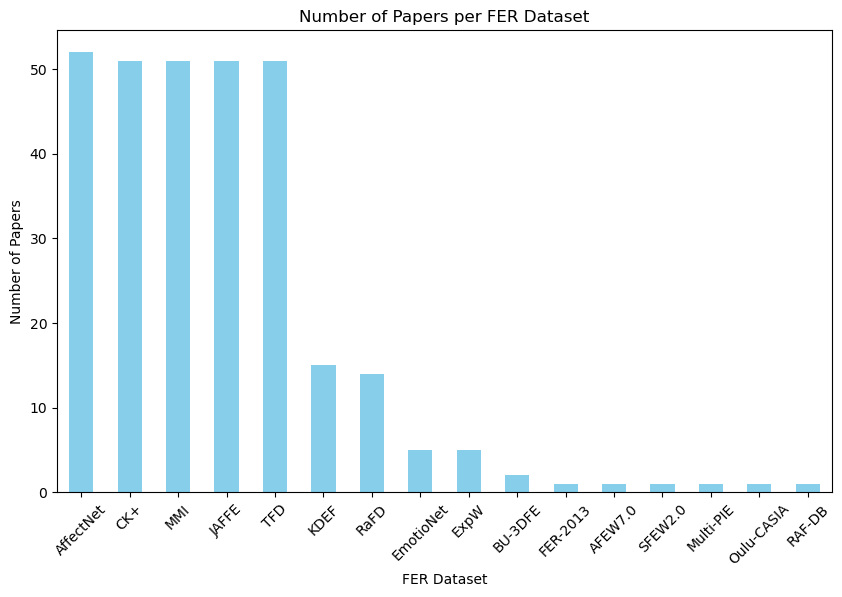

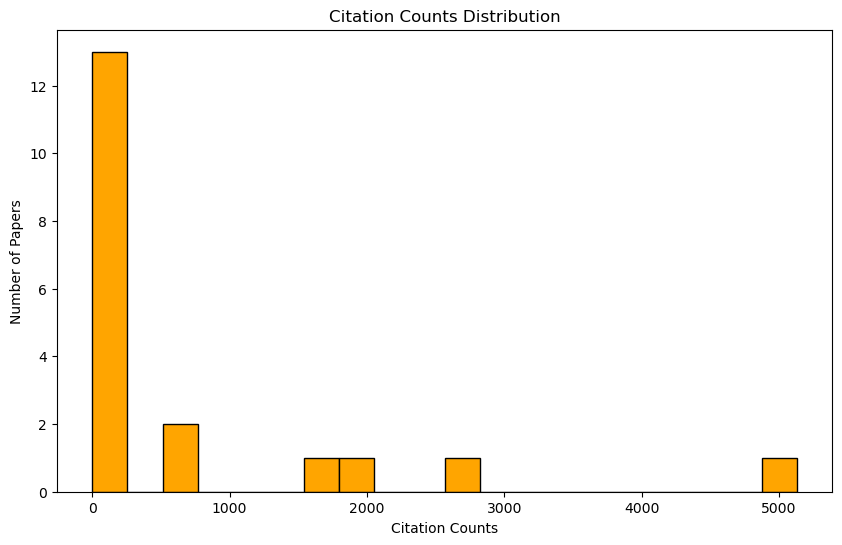

In [26]:
import matplotlib.pyplot as plt

citation_counts = combined_df['Citation Count'].dropna().astype(int)
# Combine the columns into a single 'Final Citation Count' column
combined_df['Final Citation Count'] = combined_df['Citation Count'].fillna(combined_df['Cited By'])


# Visualize the number of papers per dataset
dataset_counts = combined_df['Dataset'].value_counts()
plt.figure(figsize=(10, 6))
dataset_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Papers per FER Dataset')
plt.xlabel('FER Dataset')
plt.ylabel('Number of Papers')
plt.xticks(rotation=45)
plt.show()

# Visualize citation counts distribution
citation_counts = combined_df['Final Citation Count'].dropna().astype(int)
plt.figure(figsize=(10, 6))
plt.hist(citation_counts, bins=20, color='orange', edgecolor='black')
plt.title('Citation Counts Distribution')
plt.xlabel('Citation Counts')
plt.ylabel('Number of Papers')
plt.show()

## 8: Extract Performance Metrics from PDF Papers


In [21]:
def extract_performance_metrics(pdf_url):
    try:
        response = requests.get(pdf_url, stream=True)
        with open("temp.pdf", "wb") as pdf_file:
            pdf_file.write(response.content)
        
        doc = fitz.open("temp.pdf")
        text = ""
        for page in doc:
            text += page.get_text()
        
        accuracy = re.findall(r'Accuracy:?\s*([\d.]+)%?', text)
        f1_score = re.findall(r'F1 Score:?\s*([\d.]+)', text)
        
        return accuracy, f1_score
    except Exception as e:
        print(f"Error processing PDF: {e}")
        return None, None

# Example of extracting performance metrics from a paper's PDF
pdf_example_url = "https://arxiv.org/pdf/1804.08348v2.pdf"  # Replace with an actual PDF URL of interest
accuracy, f1_score = extract_performance_metrics(pdf_example_url)
print(f"Extracted Accuracy: {accuracy}")
print(f"Extracted F1 Score: {f1_score}")

Extracted Accuracy: []
Extracted F1 Score: []
